<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performig Neural Style Transfer
In neural style transfer, we have a content image and a style image, and we combine these two images in such a way that the combined image preserves the content of the content image while maintaining the style of the style image.  

an example of style image and content image is as follows:  
![img](image_style_transfer.png)
we want to retain the content in the picture on right (the content image), but overlay it with the color and texture in the picture on the left (the style image).


The process of performing neural style transfer is as follows: We try to modify the original image in a way that the loss value is split into **content loss** and **style loss**. 
- Content loss refers to how **different** the generated image is from the content image.  
  in practice, we modify it slightly by ensuring that the loss is calculated using the feature layer activations of images and not the original images.  
  so for example, the content loss at layer 2 will be the squared difference between the activations of the content image and the generated image when passed through the second layer.
- Style loss refers to how **correlated** the style image is to the generated image.


Loss is calculated on feature layers and not the original image, as the feature layers capture certain attributes of the original image (for example, the outline of the foreground corresponding to the original image in the higher layers and the details of fine-grained objects in the lower layers).  


**Cacluating similarity between generated image and style image**  
Gram matrix calculates the similarity between a generated image and a style image, and is calculated as follows:  
![img2](gram_matrix.png)  

GM[l] is the gram matrix value at layer l for the style image, S, and the generated image, G.  
A gram matrix results from multiplying a matrix by the transpose of itself. Let's understand the use of this operation.  
Imagine that you are working on a layer that has a feature output of 32 x 32 x 256. The gram matrix is calculated as the correlation of each of the 32 x 32 values in a channel with respect to the values across all channels. Thus, the gram matrix calculation results in a matrix that is 256 x 256 in shape. We now compare the 256 x 256 values of the style image and the generated image to calculate the style loss.  

Why is GramMatrix important for style transfer?  


In a successful scenario, say we transferred Picasso's style to the Mona Lisa. Let's call the Picasso style St (for style), the original Mona Lisa So (for source), and the final image Ta (for target). Note that in an ideal scenario, the local features in image Ta are the same as the local features in St. Even though the content might not be the same, getting similar colors, shapes, and textures as the style image into the target image is what is important in style transfer.  

By extension, if we were to send So and extract its features from an intermediate layer of VGG19, they will vary from the features obtained by sending Ta. However, within each feature set, the corresponding vectors will vary relatively with each other in a similar fashion. Say, for example, the ratio of the mean of the first channel to the mean of the second channel in both the feature sets will be similar. This is why we are trying to compute using Gram Loss.  


the final modified input image is the image that minimizes the overall loss, that is, a weighted average of the style and content loss.  


The high-level strategy we adopt to implement neural style transfer is as follows:

1. Pass the input image through a pre-trained model.
2. Extract the layer values at pre-defined layers.
3. Pass the generated image through the model and extract its values at the same pre-defined layers.
4. Calculate the content loss at each layer corresponding to the content image and generated image.
5. Pass the style image through multiple layers of the model and calculate the gram matrix values of the style image.
6. Pass the generated image through the same layers that the style image is passed through and calculate its corresponding gram matrix values.
7. Extract the squared difference of the gram matrix values of the two images.  
This will be the style loss.
8. The overall loss will be the weighted average of the style loss and content loss.
9. The input image that minimizes the overall loss will be the final image of interest.

In [1]:
# !pip install torch_snippets
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from torchvision.models import vgg19
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [3]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval() 
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x


In [4]:
vgg = vgg19_modified().to(device)

In [ ]:
!wget https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
!wget https://www.dropbox.com/s/1svdliljyo0a98v/style_image.png

In [5]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style_image.png', '60.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [6]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

Specify the layers that define content loss and style loss, that is, which intermediate VGG layers we are using, to compare gram matrices for style and raw feature vectors for content

In [13]:
style_layers = [0, 5, 10, 19, 28] 
content_layers = [21]
loss_layers = style_layers + content_layers

In [14]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [15]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]] 
content_weights = [1]
weights = style_weights + content_weights

We need to manipulate our image such that the style of the target image resembles style_image as much as possible. Hence we compute the style_targets values of style_image by computing GramMatrix of features obtained from a few chosen layers of VGG. Since the overall content should be preserved, we choose the content_layer variable at which we compute the raw features from VGG

In [16]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

Even though we could have used Adam or any other optimizer, LBFGS is an optimizer that has been observed to work best in deterministic scenarios. Additionally, since we are dealing with exactly one image, there is nothing random. Many experiments have revealed that LBFGS converges faster and to lower losses in neural transfer settings, so we will use this optimizer

In [17]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])
log = Report(max_iters)

In [18]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000	loss: 9646976.000	(61.04s - -0.24s remaining)))ing)

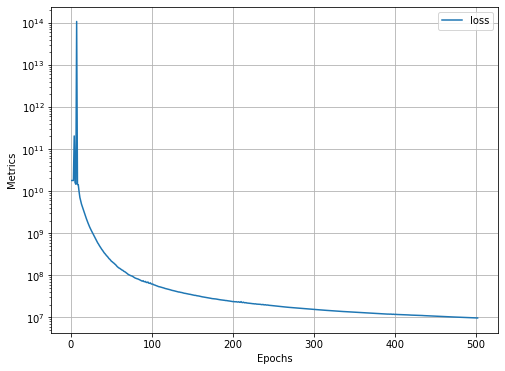

In [19]:
log.plot(log=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


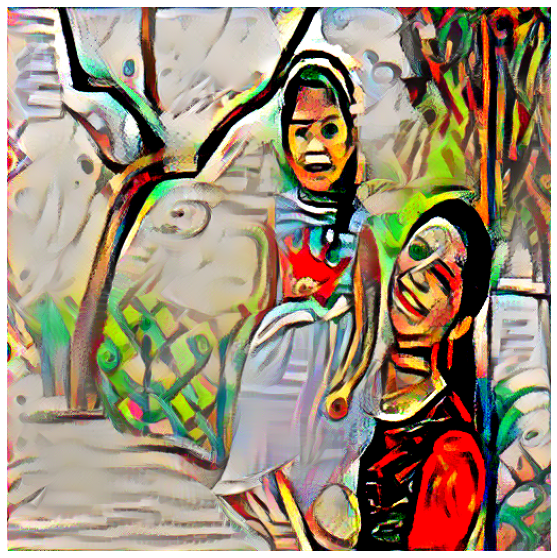

In [20]:
out_img = postprocess(opt_img[0].detach()).permute(1,2,0)
show(out_img)